In [2]:
# Imports and libs
import os
import os.path
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import io
import scipy.misc
import numpy as np

# For TF 1
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tensorflow as tf
import tensorflow_hub as hub

from concurrent.futures import ThreadPoolExecutor

import time

tf.get_logger().setLevel('ERROR')

In [3]:
# List of all models endorsed by the official tf object detection tutorial that were trained on the COCO 2017 training set
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

In [10]:
# Load images from inputs folder
IMAGES = []
VALID_PATHS = []
running = []

# Get all valid image paths
file_path = 'inputs/colorized_stable/' # use colorized_artistic for artistic model
for image_path in os.listdir(file_path)[::10]:
    if (image_path.endswith('.jpg')):
        # Collect image as valid path
        VALID_PATHS.append(image_path)

# Load given image into numpy array using matplotlib imload
def load_valid_image(path):
    img = mpimg.imread(file_path + path, format='jpg')
    # Reshape image array to fit specifications required by tensorflow model
    (rows, columns, channels) = img.shape
    IMAGES.append(img.reshape((1, rows, columns, channels)))
    print('Load image: ' + image_path)

# Parallelize execution with threadpool
def run_with_Threadpool(paths):
    with ThreadPoolExecutor(max_workers=(os.cpu_count() * 5)) as executor:
        # Schedule task for each image
        running = [executor.submit(
            lambda: load_valid_image(path)
        ) for path in paths]

"""
    Since we are working with a lot of IO operations, we use Threadpool since it is much faster for IO than using Processes:
    
    Loading 20 images:
        Runtime with Processes: ~20 seconds
        Runtime with Threadpool: ~3 seconds
"""
# Load all valid images
# start_time = time.time()
run_with_Threadpool(VALID_PATHS)
# print("--- Runtime with Threadpool: %s seconds ---" % (time.time() - start_time))

print("All images loaded")

Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpgLoad image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg

Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpgLoad image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg

Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
Load image: {E 18 III_RF KB 238} Bild 0001 (KB-Film 238 Aufn. 1) [aid 2-3030464-1].jpg
All images loaded


In [5]:
# Load object detection lib
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [6]:
# Path to predefined labels for the coco 2017 training set
PATH_TO_LABELS = './tensorflow_models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [8]:
# Select model
model_display_name = 'EfficientDet D7 1536x1536'
model_handle = ALL_MODELS[model_display_name]

print('Selected model: '+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

# Load model
# Models in TF 2 format
# hub_model = hub.load(model_handle)
# Models in TF 1 format
hub_model = hub.load(model_handle)
print('Model loaded!')

Selected model: EfficientDet D7 1536x1536
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/efficientdet/d7/1


Model loaded!


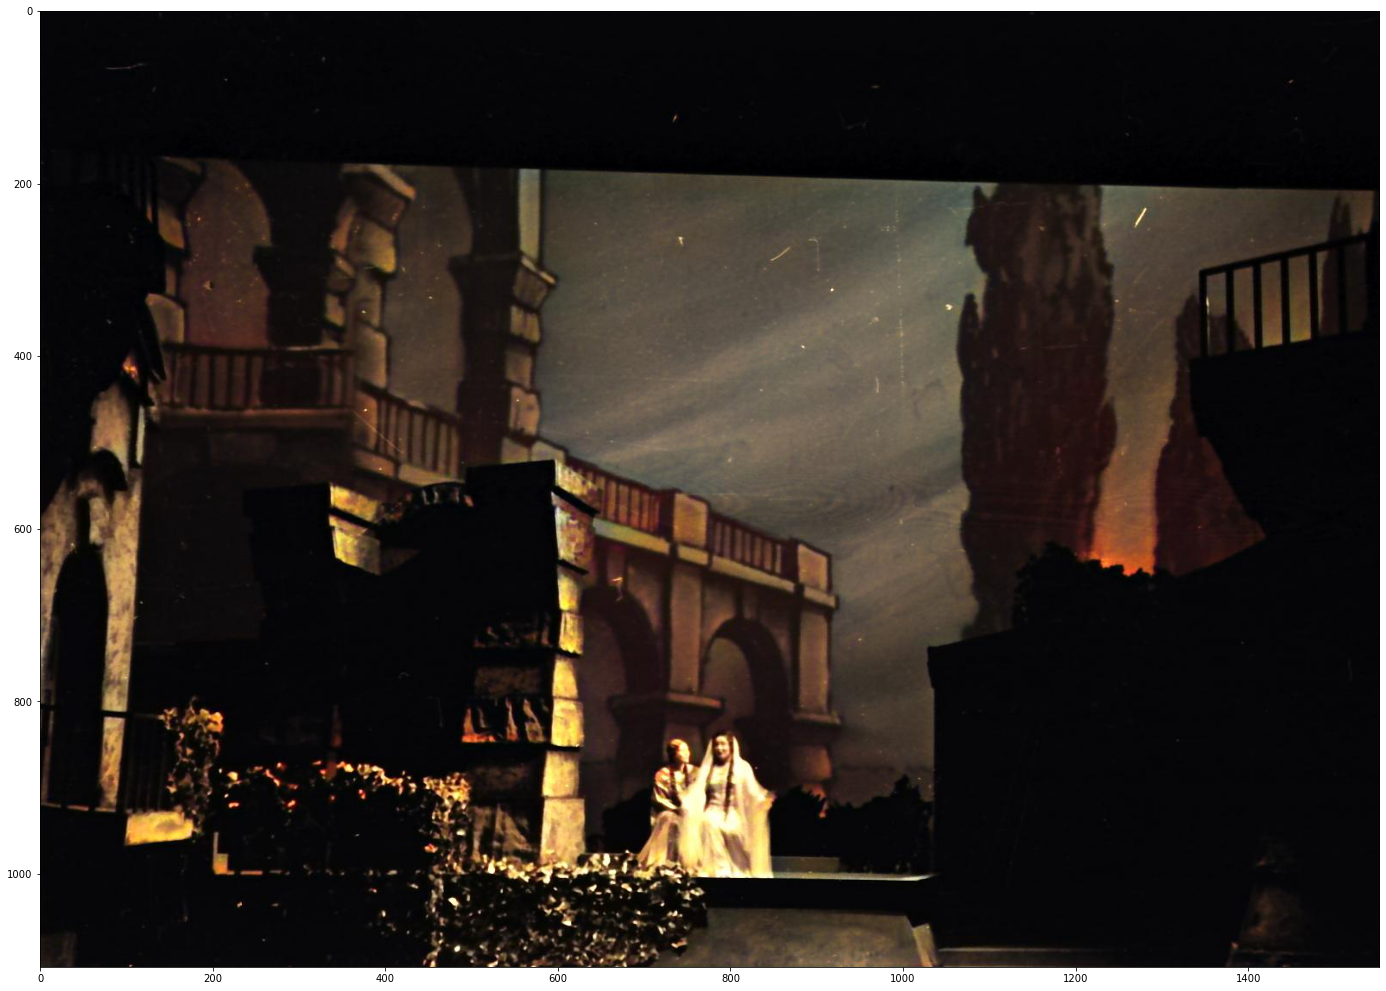

In [11]:
# Draw first image
plt.figure(figsize=(24,32))
plt.imshow(IMAGES[0][0])
plt.show()

In [12]:
# running inference
# different object detection models have additional results
# all of them are explained in the documentation
result = []
count = len(IMAGES)
i = 1
percentage = ''

start_time = time.time()
for image in IMAGES:
    # Run object detection and save results
    detected = hub_model(image)
    result.append({key:value.numpy() for key,value in detected.items()})
    
    # Get percentage
    percentage = (i / count) * 100
    # Print percentage
    print(f'{percentage:.1f}' + '%')
    i += 1
    
runtime = ((time.time() - start_time) / 60)
print("--- Runtime: " + f'{runtime:.2f}' + " minutes ---")

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
--- Runtime: 4.14 minutes ---


In [13]:
# Setup offset and copy image to draw detected objects
label_id_offset = 0

IMAGES_WITH_DETECTION = []
for image in IMAGES:
    IMAGES_WITH_DETECTION.append(image.copy())

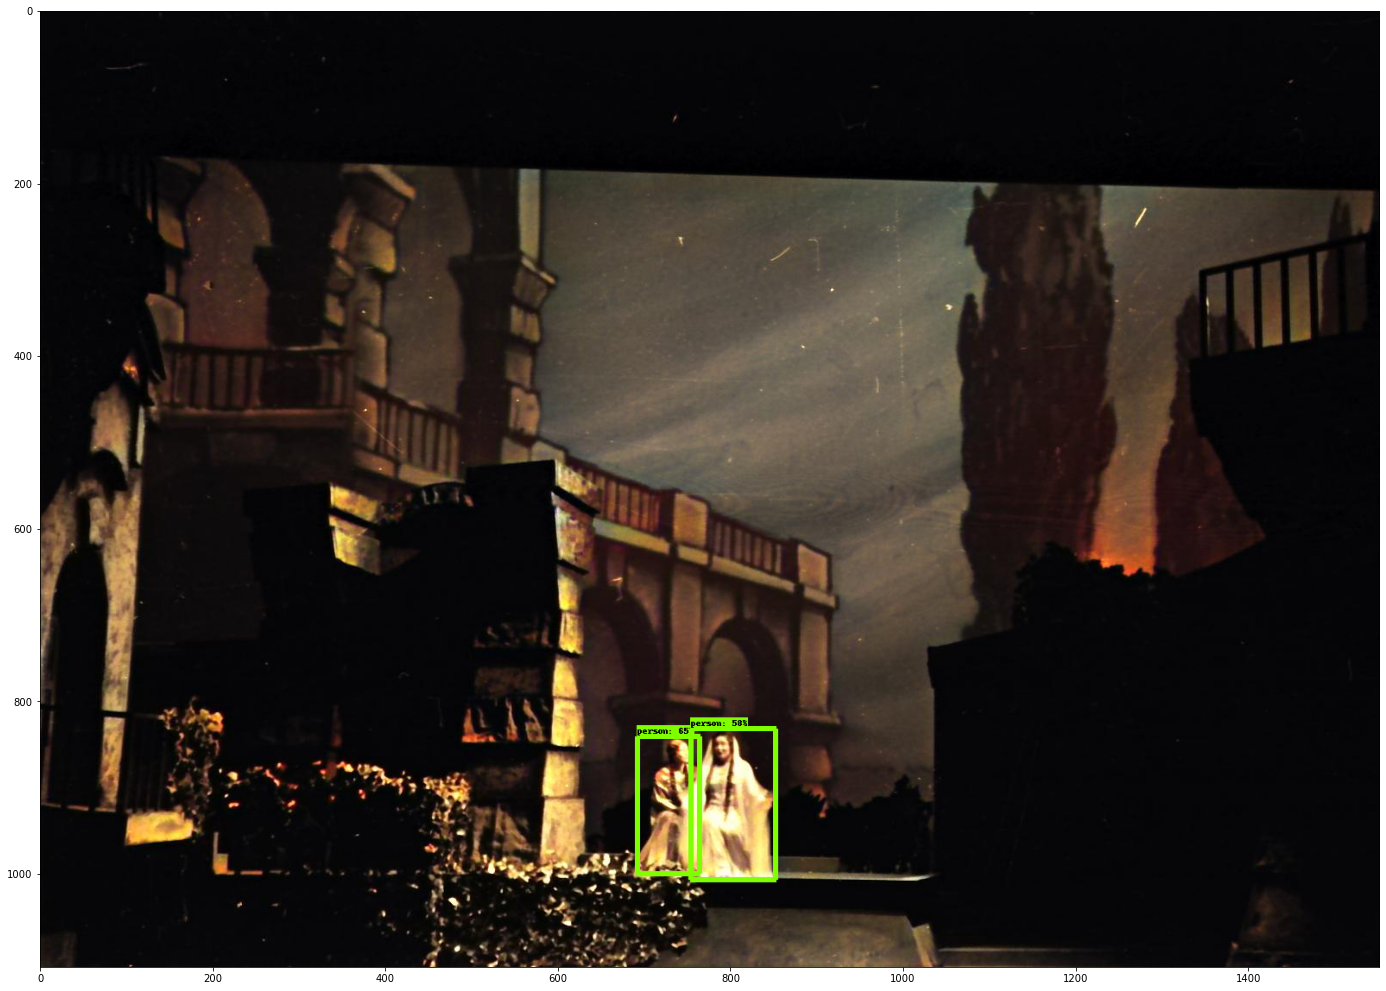

In [14]:
# Draw detections on copied image
i = 0
for image_wd in IMAGES_WITH_DETECTION:
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_wd[0],
          result[i]['detection_boxes'][0],
          (result[i]['detection_classes'][0] + label_id_offset).astype(int),
          result[i]['detection_scores'][0],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          # Change this if confidence score should be higher or lower
          min_score_thresh=.50,
          line_thickness=6,
          agnostic_mode=False
    )
    i += 1

# Draw first new image
plt.figure(figsize=(24,32))
plt.imshow(IMAGES_WITH_DETECTION[0][0])
plt.show()

In [15]:
# Add output sub-directory named after the model that was used (if it doesn't already exist)
output_dir = 'outputs/' + model_display_name + '/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
# Save images
i = 0
for image in IMAGES_WITH_DETECTION:
    plt.imsave(output_dir + VALID_PATHS[i] + '_' + model_display_name + '.jpg', image[0], format='jpg')
    i += 1